In [1]:
import argparse
import os
import ruamel.yaml as yaml
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path
import pandas as pd 
import math 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from torch.utils.data import DataLoader

from models.model_retrieval import ALBEF
from models.vit import interpolate_pos_embed
from models.tokenization_bert import BertTokenizer

import utils
from dataset import create_dataset, create_sampler, create_loader
from scheduler import create_scheduler
from optim import create_optimizer
import matplotlib.pyplot as plt 
import cv2 

# ! 임시코드 
def from_false_to_unusable_bg(aug_json):
    temp = [] 
    for id,value in aug_json.items():
        try:
            temp.append([id,value['obj_bg']])
        except:
            temp.append([id,value['obj_bool']])
    df = pd.DataFrame(temp)        
    df.columns = ['id','obj_bg']
    
    false_ids = df[df['obj_bg']==False]['id'].values
    for id in false_ids:
        aug_json[id].pop('obj_bool')
        aug_json[id]['obj_bg'] = 'unusable_bg'
        
    save_json = [temp,aug_json]
    with open('./data/COCO/Annotations/train2014_rmg_0.01_bbox_center_0.7.json','w') as f:
        json.dump(save_json,f)

def make_df(aug_json):
    temp = [] 
    for id,value in aug_json.items():
        try:
            temp.append([id,value['obj_bg']])
        except:
            temp.append([id,value['obj_bool']])
    #df = pd.DataFrame(temp)        
    #df.columns = ['id','obj_bg']
    return temp


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from augmentation import RoMixGen,MixGen
from dataset.caption_dataset import re_train_dataset
from torchvision import transforms 
from dataset.randaugment import RandomAugment
from PIL import Image 


config = yaml.load(open('./configs/Retrieval_coco.yaml'),Loader=yaml.Loader)
ann_file = json.load(open(config['train_file'][0],'r'))

train_transform = transforms.Compose([                        
                                        transforms.RandomResizedCrop(config['image_res'],scale=(0.5, 1.0), interpolation=Image.BICUBIC),
                                        transforms.RandomHorizontalFlip(),
                                        RandomAugment(2,7,isPIL=True,augs=['Identity','AutoContrast','Equalize','Brightness','Sharpness',
                                                                            'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Rotate']),     
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
                                    ])  
transform_after_mix = transforms.Compose([
                                            transforms.RandomResizedCrop(config['image_res'],scale=(0.5, 1.0), interpolation=Image.BICUBIC),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
                                        ])
romixgen = RoMixGen(json_file              = json.load(open('./data/COCO/Annotations/train2014_rmg_all.json')),
                    image_root             = './data/COCO/Images_0.01_bbox_center_0.7/',
                    transform_after_mix    = transform_after_mix,
                    normal_image_root      = config['image_root'],
                    normal_image_transform = train_transform,
                    resize_ratio           = 1 # hyper parameter  사이즈 
                    )

mixgen = MixGen(ann_file   = config['train_file'][0],
                image_root = config['image_root'],
                transform  = train_transform
                )

trainset = re_train_dataset(ann_file     = config['train_file'],
                            romixgen     = romixgen,
                            #romixgen     = mixgen,
                            transform    = train_transform,
                            image_root   = config['image_root'],
                            mixgen_ratio = 1, # hyper parameter 확률 0 ~ 1값 
                            mixgen       = True
                            )
trainloader = DataLoader(dataset   = trainset,
                         batch_size = 16,
                         shuffle    = True)

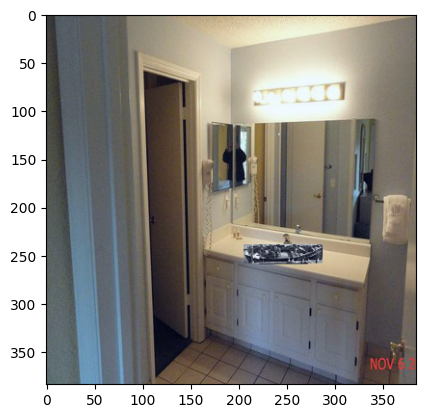

In [10]:
from torch.utils.data import DataLoader 

image,caption,id = trainset.__getitem__(800)

img = torch.permute(image,dims=(1,2,0)).detach().numpy()
plt.imshow((img-np.min(img)) / (np.max(img)-np.min(img)))
plt.show()

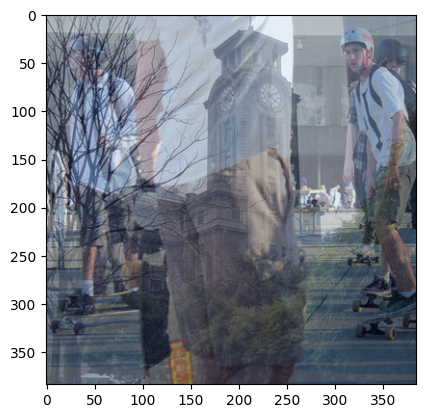

In [19]:
from torch.utils.data import DataLoader 

#image,caption,id = next(iter(trainloader))
image,caption,id = trainset.__getitem__(10000)
#ann = ann_file[800]
#ann = ann_file[1800]
#image,caption = romixgen(ann)
#image,caption,id = trainset.__getitem__(10000)
img = torch.permute(image,dims=(1,2,0)).detach().numpy()
plt.imshow((img-np.min(img)) / (np.max(img)-np.min(img)))
plt.show()

In [23]:
aug_json = json.load(open('./data/COCO/Annotations/train2014_rmg_0.01_bbox_center_0.7.json'))

In [54]:
df = aug_json[0]
df = {i[0]:i[1] for i in df }
df = pd.DataFrame.from_dict(df, orient='index',columns=['obj_bg'])

In [57]:
aug_json[0] = df 